# Human Data Analytics




- Asal Rangrazi Asl






 # lung disease prediction from X-ray images : (C3)

### Dataset description :

The dataset collects the images from several institutes, it contains Three classes (COVID19,pneumonia,normalchest) which each of them has 1525 X-ray images.

### step of project :

- loading and udnerstanding about the dataset.
- Compose the model.
- Train the model.
- Evaluate the model.

![deep_chest.jpg](attachment:deep_chest.jpg)

In [ ]:
import os
import pandas as pd
import glob
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, BatchNormalization, MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169
import cv2
from sklearn.metrics import multilabel_confusion_matrix
import tqdm
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, roc_curve

### loading the dataset :
- loading and calling the dataset with using generate_dataset_from_directory function.

- It will return a Dataset that yields batches of images from the subdirectories class_a,class_b and class_c, together with labels 0,1,2.


### Use data augmentation :

- Definition : a technique to increase the diversity of your training set by applying random (but realistic) transformations, such as image rotation.

- When we don't have a large image dataset, it's a good practice to artificially introduce sample diversity.

- This helps expose the model to different aspects of the training data and reduce overfitting.


### splitting Data :

- Data splitting is when data is divided into two or more subsets. Typically, with a two-part split, one part is used to evaluate or test the data and the other to train the model. Data splitting is an important aspect of data science, particularly for creating models based on data.



In [ ]:
folder_path='/Users/asalrangraziasl/Documents/HDA covid asal/covid19-pneumonia-normal-chest-xraypa-dataset/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset'

In [ ]:
def generate_dataset_from_directory(folder_path, size = 224,batch_size = 32):

    '''fetch all out test data from directory
    folder path is a list of n directories for n class classification '''
    #augmentation data
    image_generator = ImageDataGenerator(
        samplewise_center=True, #Set each sample mean to 0.
        samplewise_std_normalization= True, # Divide each input by its standard deviation]
        #rescale=1./255,
        validation_split = 0.3 # Randomly flip inputs vertically
    )

    #create training and testing datasets
    train_data = image_generator.flow_from_directory(directory =
        folder_path,
        class_mode="categorical",
        color_mode="grayscale",
        target_size = (size, size),
        batch_size  = batch_size,

        shuffle=True,
        seed=123,
        subset="training"
    )

    #create training and testing datasets
    val_data = image_generator.flow_from_directory(directory =
        folder_path,
        class_mode="categorical",
        color_mode="grayscale",
        target_size = (size, size),
        batch_size  = batch_size,
        shuffle=True,
        seed=123,
        subset="validation"
    )

    return train_data, val_data

def get_filepath_from_generator(gen):
    if gen.batch_index <=0:
        raise ValueError('Use iterator to move to batch_index > 0')
    idx_l = (gen.batch_index - 1) * gen.batch_size
    idx_r = idx_l + gen.batch_size if idx_l >= 0 else None
    indices = gen.index_array[idx_l:idx_r]
    filenames = [gen.filenames[i] for i in indices]
    return indices, filenames

In [ ]:
train_data, val_data = generate_dataset_from_directory(
    folder_path, size = 128,batch_size = 32)

Found 3204 images belonging to 3 classes.
Found 1371 images belonging to 3 classes.


In [ ]:
class_names = train_data.class_indices
print(class_names)

{'covid': 0, 'normal': 1, 'pneumonia': 2}


In [ ]:
classes = list(class_names.keys())
print(classes)

['covid', 'normal', 'pneumonia']


In [ ]:
images,labels = next(train_data)
indices,image_path = get_filepath_from_generator(train_data)
labels = np.argmax(labels, axis=1)
class_dict = train_data.class_indices
class_dict_inv = dict((v, k) for k, v in class_dict.items())
y_names = [class_dict_inv[key] for key in labels]

In [ ]:
print(y_names)

['pneumonia', 'pneumonia', 'normal', 'covid', 'covid', 'normal', 'normal', 'pneumonia', 'normal', 'normal', 'covid', 'covid', 'pneumonia', 'pneumonia', 'covid', 'normal', 'covid', 'normal', 'normal', 'pneumonia', 'pneumonia', 'pneumonia', 'normal', 'normal', 'covid', 'covid', 'covid', 'pneumonia', 'normal', 'pneumonia', 'normal', 'covid']


In [ ]:
print(class_dict_inv)

{0: 'covid', 1: 'normal', 2: 'pneumonia'}


covid COVID-19 (241).jpg 



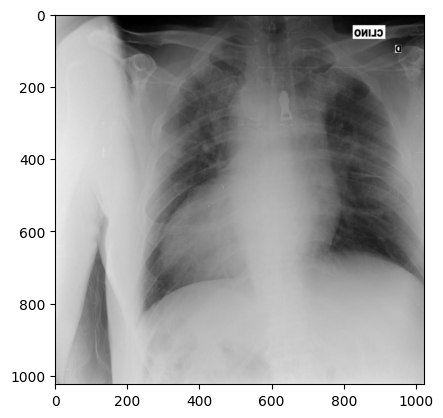

normal 00000955_000.png 



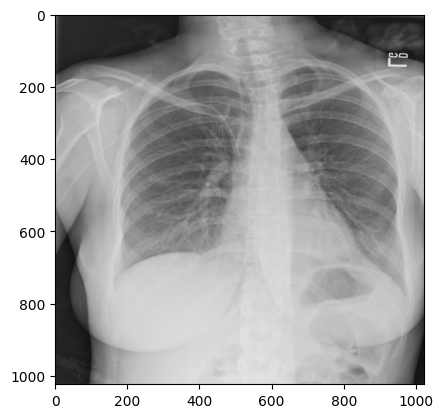

pneumonia person63_bacteria_306.jpeg 



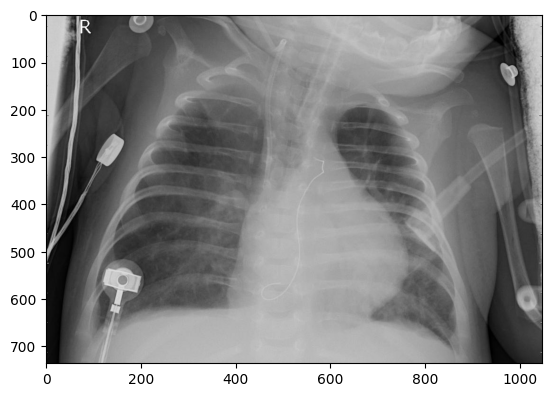

In [ ]:
#this is just simple visualization of dataset

for category in classes:
    path = os.path.join(folder_path,category)
    for img in os.listdir(path):
        print(category,img, "\n")
        img_array = cv2.imread(os.path.join(path,img))
        plt.imshow(img_array)  # graph it
        plt.show()  # display!
        break

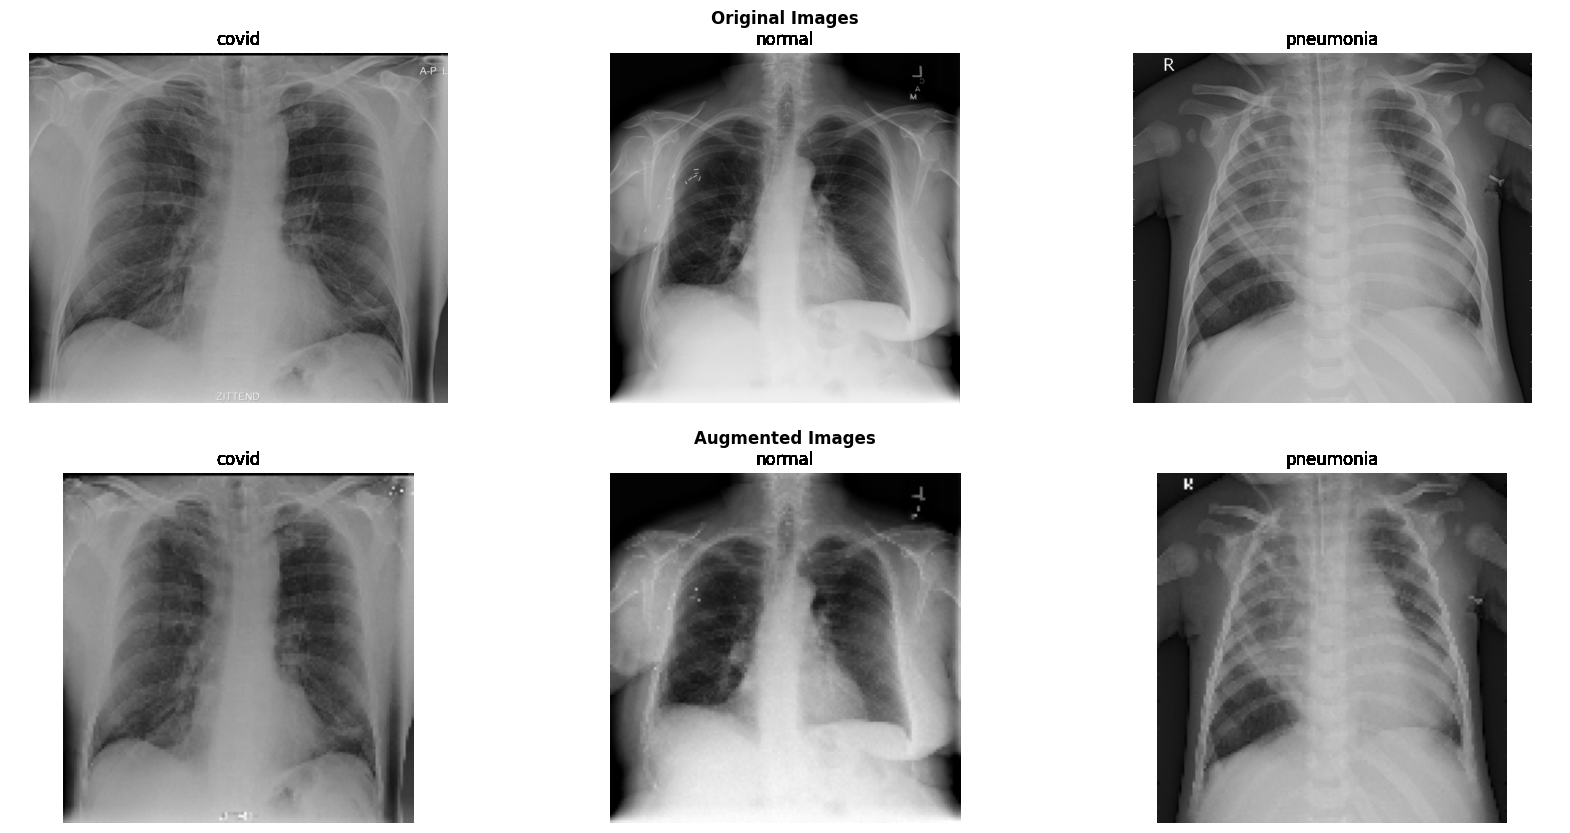

In [ ]:
# visualize the augmented images and original images

fig, big_axes = plt.subplots( figsize=(20, 10) , nrows=2, ncols=1 , sharey=True)
titles = ['Original Images','Augmented Images']
for title, big_ax in zip(titles, big_axes):
    big_ax.set_title(f'{title}\n', fontweight='semibold')
    big_ax.set_frame_on = False
    big_ax.axis('off')
for image in images:
    j  = 0
    for i in range(3):
        ax = fig.add_subplot(2, 3, i+1)
        ax1 = fig.add_subplot(2,3,i+1+3)
        for k in range(len(labels)):
            if labels[k] == j:
                og = cv2.imread(os.path.join(folder_path,image_path[k]))
                ax.imshow(og,cmap = 'gray')
                ax.set_title(classes[i])
                ax.axis("off")
                ax1.imshow(images[k],cmap = 'gray')
                ax1.set_title(classes[i])
                ax1.axis("off")
                break
        j = j+1
plt.show()

In [ ]:
print(folder_path)
print('0000')
print(image_path[2])

/Users/asalrangraziasl/Documents/HDA covid asal/covid19-pneumonia-normal-chest-xraypa-dataset/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset
0000
normal/00000430_002.png


In [ ]:
# Investigating single original image
def plot_single_image(raw_image,title):
    plt.imshow(raw_image, cmap='gray')
    plt.colorbar()
    plt.title(title)
    print(f"The dimensions of the image are {raw_image.shape[0]} pixels width and {raw_image.shape[1]} pixels height, one single color channel")
    print(f"The maximum pixel value is {raw_image.max():.4f} and the minimum is {raw_image.min():.4f}")
    print(f"The mean value of the pixels is {raw_image.mean():.4f} and the standard deviation is {raw_image.std():.4f}")
    plt.show()

The dimensions of the image are 808 pixels width and 920 pixels height, one single color channel
The maximum pixel value is 255.0000 and the minimum is 0.0000
The mean value of the pixels is 113.2454 and the standard deviation is 53.0902


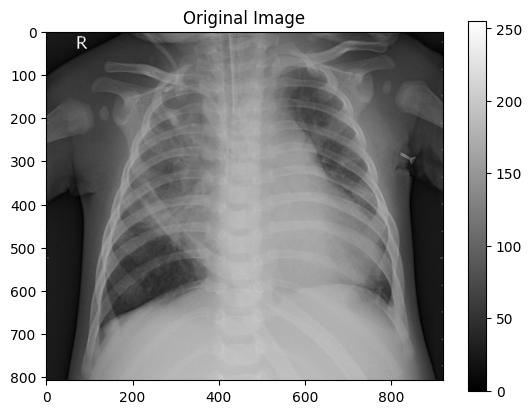

The dimensions of the image are 128 pixels width and 128 pixels height, one single color channel
The maximum pixel value is 2.6693 and the minimum is -2.1327
The mean value of the pixels is -0.0000 and the standard deviation is 1.0000


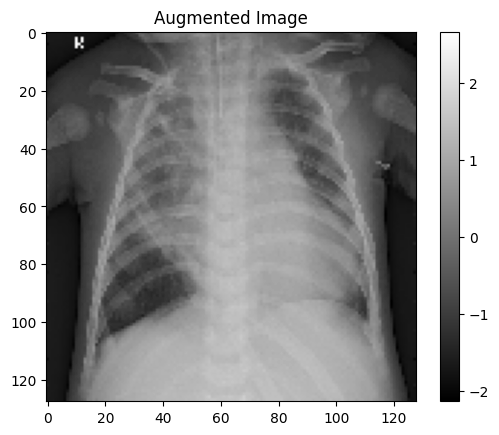

In [ ]:
plt.figure(1)
image = cv2.imread(os.path.join(folder_path,image_path[k]))
plot_single_image(image,'Original Image')
plt.figure(2)
plot_single_image(images[k],'Augmented Image')

### Image Histogram :

- An image histogram is a graphical representation of the number of pixels in an image as a function of their intensity.

- This helps us in determining how many pixels belong to a particular intensity.

/var/folders/jw/91h5jhw96l52xy2j8gdkkz7r0000gn/T/ipykernel_40978/1607448786.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(image.ravel(),
/var/folders/jw/91h5jhw96l52xy2j8gdkkz7r0000gn/T/ipykernel_40978/1607448786.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(images[k].ravel(),


<Figure size 640x480 with 0 Axes>

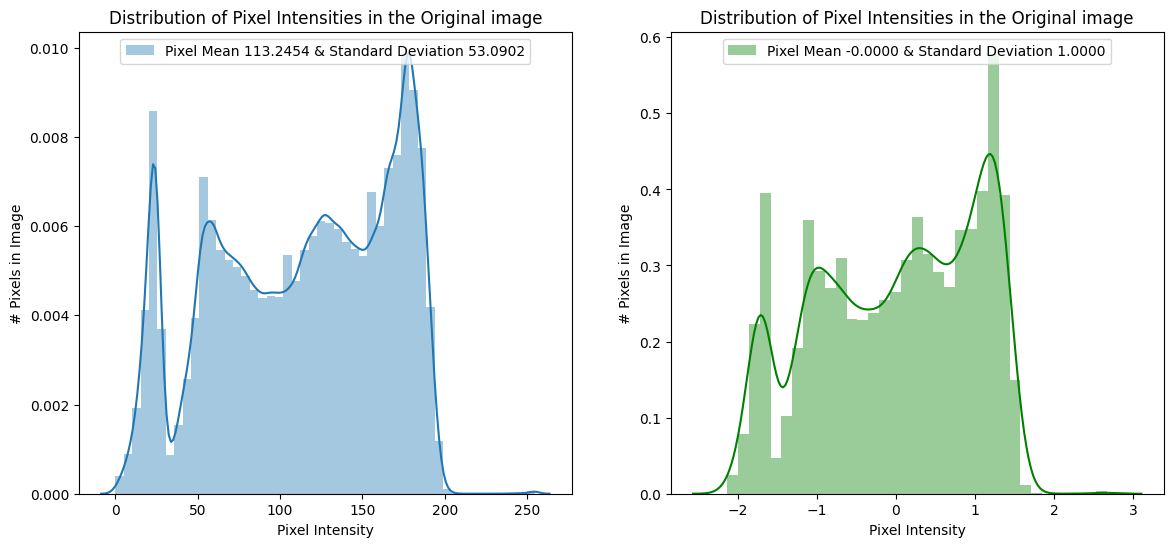

In [ ]:
# Plot a histogram of the distribution of the pixels

sns.despine(left=True)
fig,(ax1,ax2) = plt.subplots(1,2,figsize =(14,6))
sns.distplot(image.ravel(),
             label=f'Pixel Mean {np.mean(image):.4f} & Standard Deviation {np.std(image):.4f}', kde=True, ax = ax1)
ax1.legend(loc='upper center')
ax1.set_title('Distribution of Pixel Intensities in the Original image')
ax1.set_xlabel('Pixel Intensity')
ax1.set_ylabel('# Pixels in Image')

sns.distplot(images[k].ravel(),
             label=f'Pixel Mean {np.mean(images[k]):.4f} & Standard Deviation {np.std(images[k]):.4f}', kde=True,color = 'green',ax = ax2)
ax2.legend(loc='upper center')
ax2.set_title('Distribution of Pixel Intensities in the Original image')
ax2.set_xlabel('Pixel Intensity')
ax2.set_ylabel('# Pixels in Image')

plt.show()

In [ ]:
all_items,dirs,files = next(os.walk(folder_path))

In [ ]:
image_in_classes = []
for i in range(len(dirs)):
    no_of_images =len(os.listdir(os.path.join(folder_path,dirs[i])))
    image_in_classes.append(no_of_images)
df_data = {'class': dirs,'counts': image_in_classes}
classes_df = pd.DataFrame(df_data)

In [ ]:
n_classes = len(dirs)

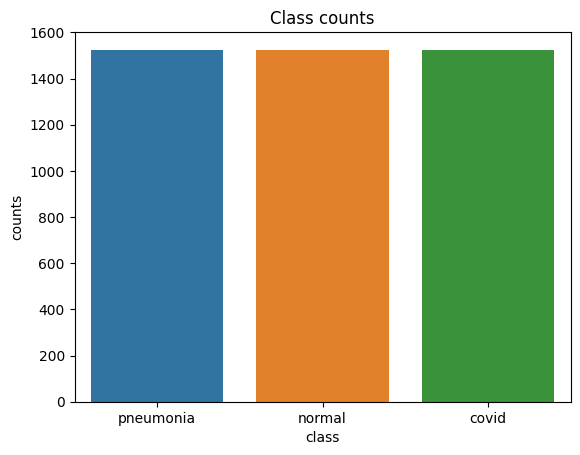

In [ ]:
sns.barplot(x = 'class', y = 'counts',data = classes_df)
plt.title('Class counts')
plt.show()

# Predictive Modeling:

### using Convolutional Neural Networks:

- A convolutional neural network, or CNN, is a deep learning neural network designed for processing structured arrays of data such as images. Convolutional neural networks are widely used in computer vision and have become the state of the art for many visual applications such as image classification.

- The architecture of a convolutional neural network is a multi-layered feed-forward neural network, made by stacking many hidden layers on top of each other in sequence. It is this sequential design that allows convolutional neural networks to learn hierarchical features.

![photo_2023-02-12_23-08-29.jpg](attachment:photo_2023-02-12_23-08-29.jpg)

# MODEL 1 :

In [ ]:
# MODEL 1:

def cnn_model(train_data,test_data, epochs,size):
#Building the model using Keras functional API
    print("----Building the model----")
    i = Input(shape=(size,size,1)) #defining input
    x = BatchNormalization()(i)
    x = Conv2D(32,3, activation= 'relu')(i) #adding convolution layers
    x = MaxPooling2D()(x)
    x = Dropout(0.2)(x)
    x = Conv2D(64, 3, activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Dropout(0.2)(x)
    x = Conv2D(128, 3, activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(3, activation= 'softmax')(x)

    model = Model(i,x)
    model.summary()
#Training the Convolutional Neural Network
    print("----Training the network----")
    model.compile(optimizer= Adam(0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss',
                               mode='min',
                               patience = 5 ,
                               restore_best_weights=True)
    #model_checkpoint
    mc = ModelCheckpoint('cnn_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    r = model.fit(train_data,
                  validation_data = val_data,
                  epochs = epochs,
                  verbose = 2,
                  batch_size = 32,
                  callbacks = [early_stop,mc])
    print("Train score:", model.evaluate(train_data))
    print("Test score:", model.evaluate(val_data))
    n_epochs = len(r.history['loss'])

    return r,model,n_epochs

In [ ]:
epochs = 20
r,model,n_epochs = cnn_model(train_data, val_data,epochs,128)

----Building the model----
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                              

2023-02-08 15:59:08.237775: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz



Epoch 1: val_loss improved from inf to 0.99041, saving model to cnn_model.h5
101/101 - 48s - loss: 0.4060 - accuracy: 0.8396 - val_loss: 0.9904 - val_accuracy: 0.7936 - 48s/epoch - 472ms/step
Epoch 2/20

Epoch 2: val_loss improved from 0.99041 to 0.84330, saving model to cnn_model.h5
101/101 - 46s - loss: 0.2715 - accuracy: 0.8951 - val_loss: 0.8433 - val_accuracy: 0.8038 - 46s/epoch - 459ms/step
Epoch 3/20

Epoch 3: val_loss did not improve from 0.84330
101/101 - 47s - loss: 0.2199 - accuracy: 0.9179 - val_loss: 0.8787 - val_accuracy: 0.8147 - 47s/epoch - 462ms/step
Epoch 4/20

Epoch 4: val_loss did not improve from 0.84330
101/101 - 47s - loss: 0.1966 - accuracy: 0.9263 - val_loss: 1.0774 - val_accuracy: 0.8023 - 47s/epoch - 464ms/step
Epoch 5/20

Epoch 5: val_loss did not improve from 0.84330
101/101 - 47s - loss: 0.1688 - accuracy: 0.9416 - val_loss: 1.0300 - val_accuracy: 0.8169 - 47s/epoch - 464ms/step
Epoch 6/20

Epoch 6: val_loss did not improve from 0.84330
101/101 - 47s - lo

### Learning curves plots:

- Learning curves are plots used to show a model's performance as the training set size increases.

- it can be used is to show the model's performance over a defined period of time. We typically used them to diagnose algorithms that learn incrementally from data.

In [ ]:
def plotLearningCurve(history,epochs):

    epochRange = range(1,epochs+1)
    fig, ax = plt.subplots(1,2,figsize=(20,10))
    ax[0].plot(epochRange,history.history['accuracy'],'g', marker ='.',markersize=15,label = 'Training Accuracy',linewidth=4)
    ax[0].plot(epochRange,history.history['val_accuracy'],'orange', marker ='*',markersize=15,label = 'Validation Accuracy',linewidth=4)
    ax[0].set_title('Training and Validation accuracy')
    ax[0].set_xlabel('Epoch', fontsize = 20)
    ax[0].set_ylabel('Accuracy', fontsize = 20)
    ax[0].legend()
    ax[0].grid(color='gray', linestyle='--')
    ax[1].plot(epochRange,history.history['loss'],'g',marker ='.',markersize=15,label = 'Training Loss',linewidth=4)
    ax[1].plot(epochRange,history.history['val_loss'],'orange', marker ='*',markersize=15,label = 'Validation Loss',linewidth=4)
    ax[1].set_title('Training and Validation loss')
    ax[1].set_xlabel('Epoch', fontsize = 20)
    ax[1].set_ylabel('Loss', fontsize = 20)
    ax[1].legend()
    ax[1].grid(color='gray', linestyle='--')
    ax[0].set_ylim([0.5, 1])
    ax[1].set_ylim([0.01, 4])
    plt.savefig('plot_HDA.png')
    plt.show()


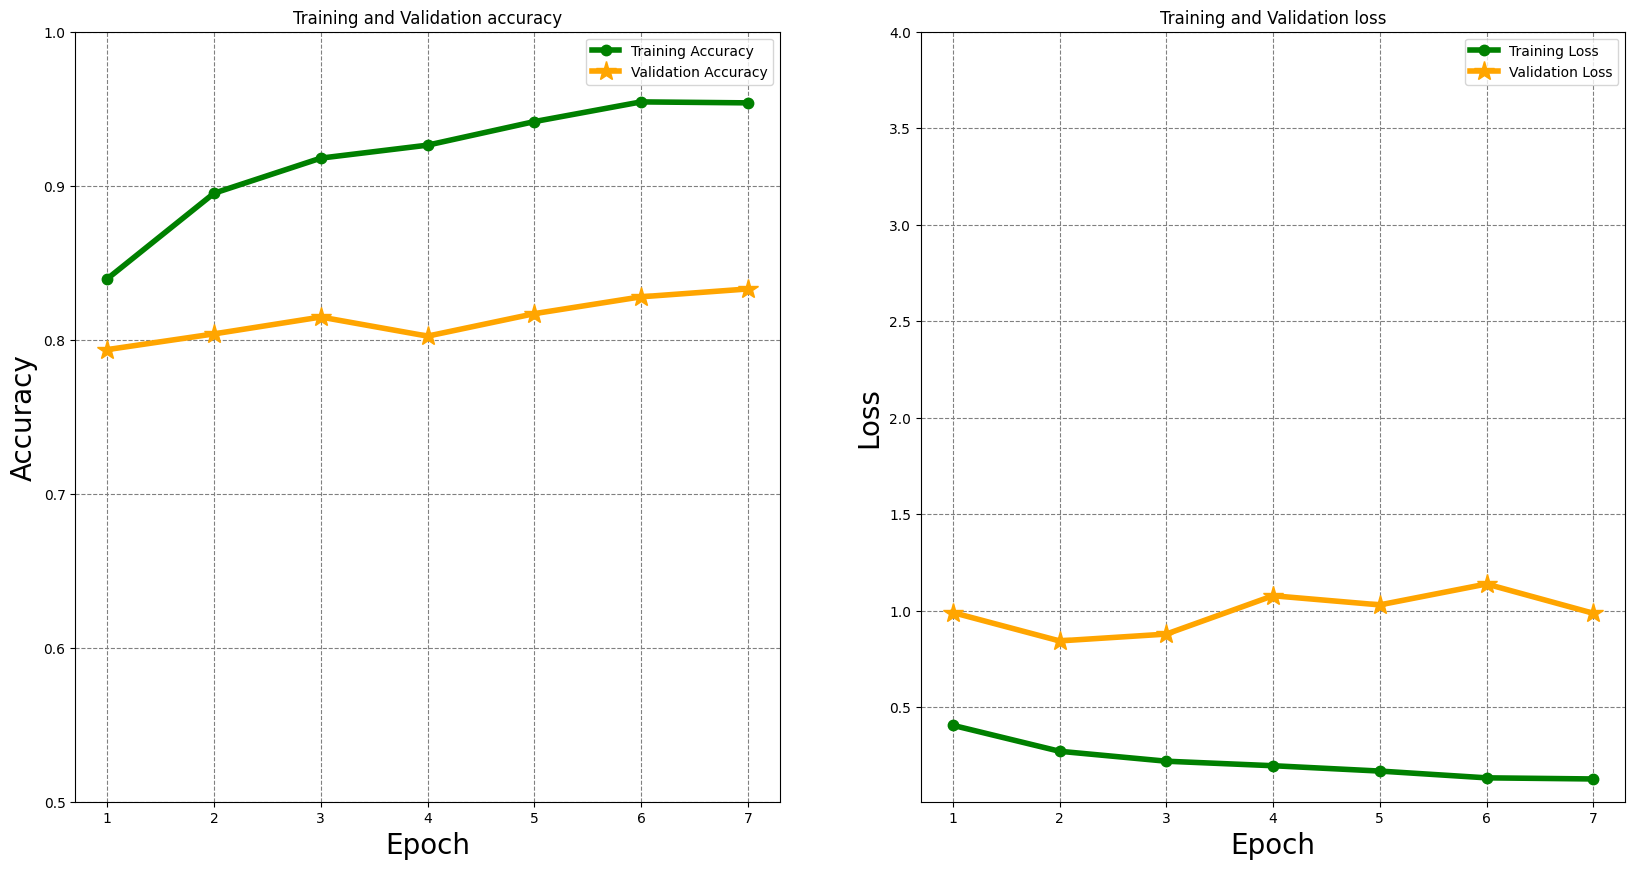

In [ ]:
plotLearningCurve(r,n_epochs)

In [ ]:
# printing model accuracy for train and test data
test_evaluation = model.evaluate(val_data)
print(f"Test Accuracy using CNN: {test_evaluation[1] * 100:.2f}%")

train_evaluation = model.evaluate(train_data)
print(f"Train Accuracy using CNN: {train_evaluation[1] * 100:.2f}%")

43/43 [==============================] - 11s 242ms/step - loss: 0.8433 - accuracy: 0.8038
Test Accuracy using CNN: 80.38%
101/101 [==============================] - 35s 343ms/step - loss: 0.2696 - accuracy: 0.9001
Train Accuracy using CNN: 90.01%


In [ ]:
def extract_from_generator(data):
    data.reset()
    X, y = next(data)
    for i in tqdm.tqdm(range(int(data.n/data.batch_size)-1)):
        img, label = next(data)
        X = np.append(X, img, axis=0 )
        y = np.append(y, label, axis=0)
    return X,y

In [ ]:
X_train,y_train = extract_from_generator(train_data)
print('X_train:',X_train.shape,'y_train:',y_train.shape)

100%|██████████| 99/99 [00:34<00:00,  2.86it/s]

X_train: (3200, 128, 128, 1) y_train: (3200, 3)


In [ ]:
X_test,y_test = extract_from_generator(val_data)
print('X_test:',X_test.shape,'y_test:',y_test.shape)

100%|██████████| 41/41 [00:10<00:00,  4.05it/s]

X_test: (1344, 128, 128, 1) y_test: (1344, 3)


In [ ]:
y_pred  = np.round(model.predict(X_test))

42/42 [==============================] - 2s 49ms/step


In [ ]:
y_test_c = np.argmax(y_test,axis = 1)
y_pred_c = np.argmax(y_pred,axis = 1)

### classification report :

- A Classification report is used to measure the quality of predictions from a classification algorithm. How many predictions are True and how many are False. More specifically, True Positives, False Positives, True negatives and False Negatives are used to predict the metrics of a classification report as shown below.

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.82      0.88       447
           1       0.65      0.95      0.77       449
           2       0.98      0.62      0.76       448

   micro avg       0.81      0.80      0.80      1344
   macro avg       0.86      0.80      0.81      1344
weighted avg       0.86      0.80      0.80      1344
 samples avg       0.80      0.80      0.80      1344



/Library/Python/3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


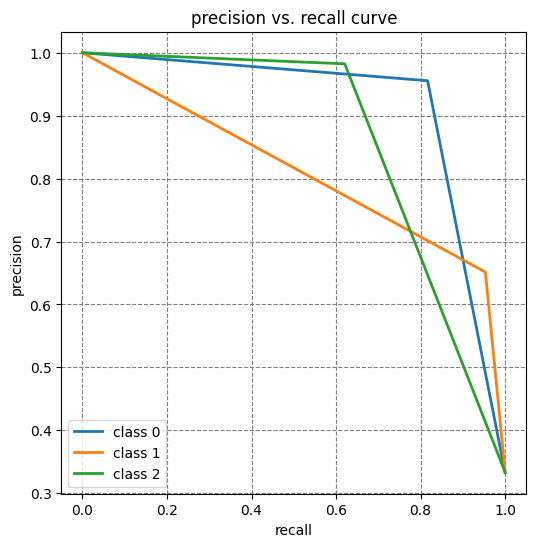

In [ ]:
plt.figure(figsize = (6,6))
precision = dict()
recall = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_pred[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.grid(color='gray', linestyle='--')
plt.savefig('precision_recall.png')
plt.show()

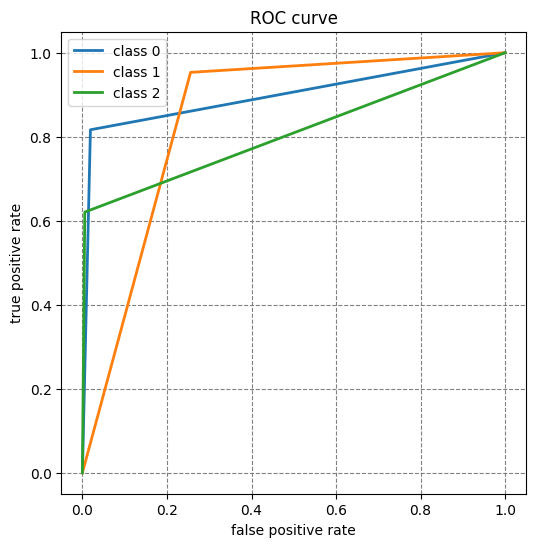

In [ ]:
plt.figure(figsize = (6,6))
fpr = dict()
tpr = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i],
                                  y_pred[:, i])
    plt.plot(fpr[i], tpr[i], lw=2, label='class {}'.format(i))

plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="best")
plt.title("ROC curve")
plt.grid(color='gray', linestyle='--')
plt.savefig('ROC_curve.png')
plt.show()

In [ ]:
def plot_confusion_matrix(cm, class_names):

    figure = plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Normalize the confusion matrix.
    cm = np.around(cm.astype('int') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.

    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            color = "white" if cm[i, j] > threshold else "black"
            plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusionMatrix.png')
    return

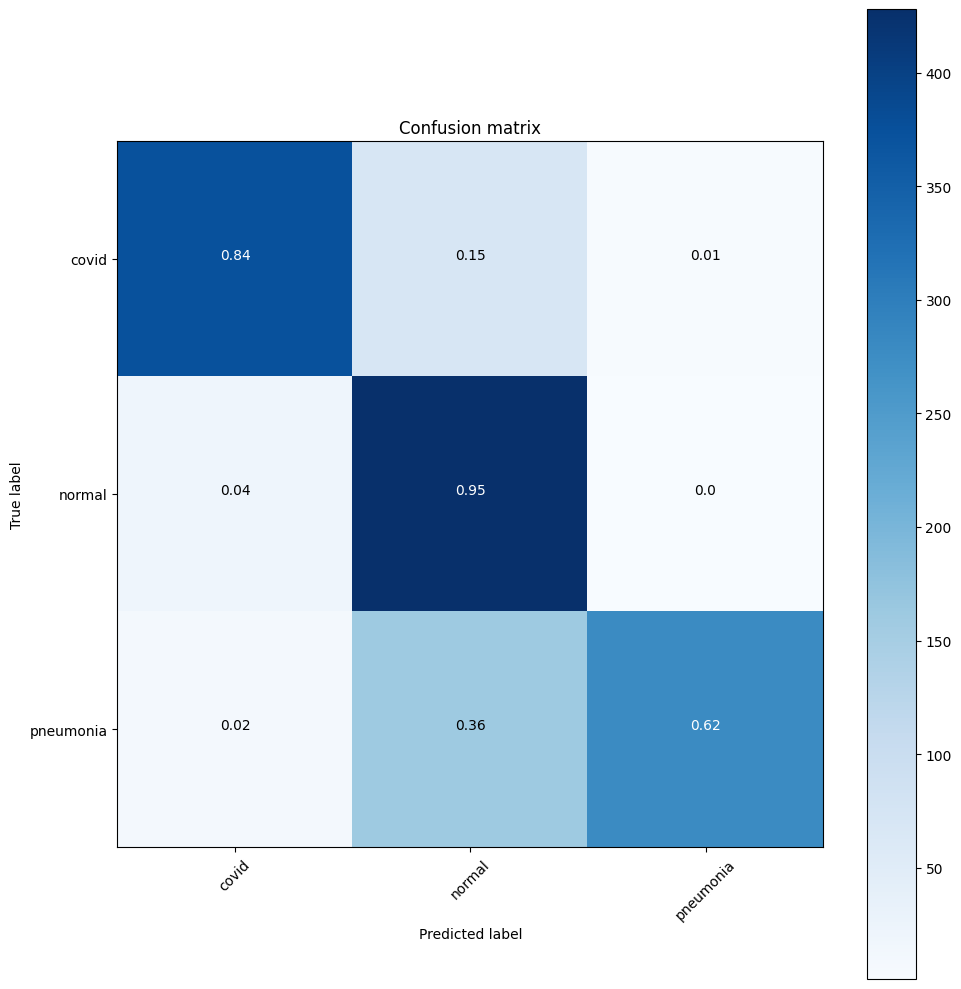

In [ ]:
#show the confusion matrix
import sklearn.metrics as metrics

confusion_matrix = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
plot_confusion_matrix(confusion_matrix, class_names)

42/42 [==============================] - 2s 52ms/step
2
2
The dimensions of the image are 128 pixels width and 128 pixels height, one single color channel
The maximum pixel value is 1.4434 and the minimum is -2.4678
The mean value of the pixels is -0.0000 and the standard deviation is 1.0000


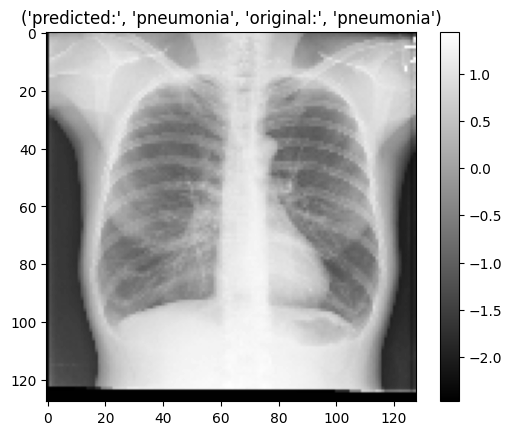

In [ ]:
#sample code

n = 20
y_pred_t = model.predict(X_test)
print(y_test[n].argmax())
print(y_pred_t[n].argmax())
titel='predicted:',class_dict_inv[y_pred_t[n].argmax()],'original:',class_dict_inv[y_test[n].argmax()]
plot_single_image(X_test[n],titel)

42/42 [==============================] - 2s 55ms/step
1
1
The dimensions of the image are 128 pixels width and 128 pixels height, one single color channel
The maximum pixel value is 1.9981 and the minimum is -1.7557
The mean value of the pixels is -0.0000 and the standard deviation is 1.0000


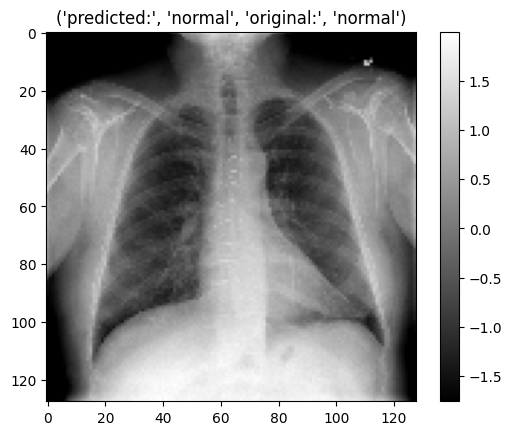

In [ ]:

n = 501
y_pred_t = model.predict(X_test)
print(y_test[n].argmax())
print(y_pred_t[n].argmax())
titel='predicted:',class_dict_inv[y_pred_t[n].argmax()],'original:',class_dict_inv[y_test[n].argmax()]
plot_single_image(X_test[n],titel)

42/42 [==============================] - 2s 55ms/step
0
0
The dimensions of the image are 128 pixels width and 128 pixels height, one single color channel
The maximum pixel value is 1.8197 and the minimum is -2.6370
The mean value of the pixels is 0.0000 and the standard deviation is 1.0000


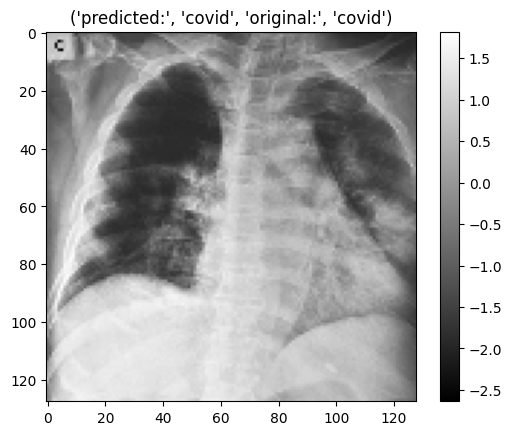

In [ ]:
n = 800
y_pred_t = model.predict(X_test)
print(y_test[n].argmax())
print(y_pred_t[n].argmax())
titel='predicted:',class_dict_inv[y_pred_t[n].argmax()],'original:',class_dict_inv[y_test[n].argmax()]
plot_single_image(X_test[n],titel)

# MODEL 2:

### Transfer learning & fine-tuning :

- Definition : Transfer learning (TL) is a research problem in machine learning (ML) that focuses on storing knowledge gained while solving one problem and applying it to a different but related problem.

- we will use transfer learning to classify images of ('covid', 'normal', 'pneumonia') from a pre-trained network.

- The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

![xst-28-xst200715-g001.jpeg](attachment:xst-28-xst200715-g001.jpeg)

### DenseNets :

- Dense net is densely connected-convolutional networks.

- A DenseNet utilises dense connections between layers, through Dense Blocks, where we connect all layers (with matching feature-map sizes) directly with each other.

- DenseNet was specially developed to improve accuracy caused by the vanishing gradient in high-level neural networks due to the long distance between input and output layers & the information vanishes before reaching its destination.




In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
dataset = tf.keras.utils.image_dataset_from_directory(      folder_path,
                                                            shuffle=True,
                                                            batch_size= BATCH_SIZE,
                                                            image_size= IMG_SIZE    )

Found 4575 files belonging to 3 classes.


In [ ]:
def get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    if shuffle:s
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)


    return train_ds, val_ds, test_ds

In [ ]:
train_dataset, validation_dataset, test_dataset = get_dataset_partitions_tf( dataset, ds_size=len(dataset))

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [ ]:
rescale = tf.keras.layers.Rescaling(1./255, offset=0.0)

# Download the densenet preprocessing tool

preprocess_input = tf.keras.applications.densenet.preprocess_input

### Create the base model from the pre-trained convnets :

- Tensorflow and the pre-trained model can be used to create a base model from pre-trained convolutional networks.

- We use the densely connected neural networks of type Densenet121.

- It takes the weights, and the input shape of the image as parameters.

- Optionally we load weights pre-trained on ImageNet.

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)

base_model = tf.keras.applications.DenseNet121(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

### Pretrained model for features extraction :

- Use a pre-trained model to extract meaningful features from new samples.

- Simply add a new classifier, which will be trained from scratch, on top of the pre-trained model.

- Repurpose the feature maps learned previously for the dataset.

- Do not need to re-train the entire model.

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

2023-02-04 16:07:54.355755: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 112 of 10000
2023-02-04 16:07:56.183365: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


(32, 7, 7, 1024)


### Freeze the convolutional base:

- It is important to freeze the convolutional base before you compile and train the model.

- Freezing a layer in the context of neural networks is about controlling the way the weights are updated. When a layer is frozen, it means that the weights cannot be modified further.

- This technique is often used in transfer learning, where the base model(trained on some other dataset)is frozen.Freezing a layer prevents its weights from being modified.

-  Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training.

In [ ]:
base_model.trainable = True

In [ ]:
base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_16 (ZeroPadding  (None, 230, 230, 3)  0          ['input_13[0][0]']               
 2D)                                                                                              
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_16[0][0]']      
                                )                                                       

In [ ]:
# Add a classification head

# In order to generate predictions from the block of features, average over the
# spatial 5 x 5 spatial locations, using tf.keras.layers.GlobalAveragePooling2D
# layer to convert the features to a single vector per image.

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1024)


In [ ]:
# Now we'll convert these features into a single prediction per image.
# We don't need an activation function here because this prediction
# will be treated as a logit, or a raw prediction value.

prediction_layer = tf.keras.layers.Dense(3,activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=True)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
#COMPILE THE MODEL

#Compile the model before training it, since there are three classes we'll use SparseCategoricalCrossEntropy.
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss= tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                           

In [ ]:
len(model.trainable_variables)

364

In [ ]:
initial_epochs = 4

loss0, accuracy0 = model.evaluate(validation_dataset)

2023-02-04 16:09:58.565685: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 123 of 10000
2023-02-04 16:09:59.499195: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


14/14 [==============================] - 31s 1s/step - loss: 1.1165 - accuracy: 0.4174


In [ ]:
print("initial loss:", loss0)
print("initial accuracy:",accuracy0)

initial loss: 1.1165004968643188
initial accuracy: 0.4174107015132904


In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

weight_path="{}_weights.best.hdf5".format('covid_19')

checkpoint = ModelCheckpoint(weight_path,
                             save_best_only=True, save_weights_only = True)

early = EarlyStopping(monitor="val_loss", mode="min", patience=5)

callbacks_list = [checkpoint, early]

history = model.fit(train_dataset,epochs=initial_epochs,validation_data=validation_dataset, callbacks = callbacks_list)

Epoch 1/4


2023-02-04 16:11:23.584511: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 117 of 10000
2023-02-04 16:11:25.031555: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


114/114 [==============================] - ETA: 0s - loss: 0.3348 - accuracy: 0.8876

2023-02-04 16:21:07.918433: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 122 of 10000
2023-02-04 16:21:08.905682: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


114/114 [==============================] - 630s 5s/step - loss: 0.3348 - accuracy: 0.8876 - val_loss: 0.2448 - val_accuracy: 0.9306
Epoch 2/4


2023-02-04 16:21:37.908521: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 122 of 10000
2023-02-04 16:21:38.919169: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


114/114 [==============================] - ETA: 0s - loss: 0.2045 - accuracy: 0.9339

2023-02-04 16:31:18.930707: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 125 of 10000
2023-02-04 16:31:19.688822: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


114/114 [==============================] - 610s 5s/step - loss: 0.2045 - accuracy: 0.9339 - val_loss: 0.2016 - val_accuracy: 0.9308
Epoch 3/4


2023-02-04 16:31:48.298761: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 126 of 10000
2023-02-04 16:31:48.920750: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


114/114 [==============================] - ETA: 0s - loss: 0.1681 - accuracy: 0.9463

2023-02-04 16:41:19.609707: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 125 of 10000
2023-02-04 16:41:20.340766: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


114/114 [==============================] - 601s 5s/step - loss: 0.1681 - accuracy: 0.9463 - val_loss: 0.1475 - val_accuracy: 0.9509
Epoch 4/4


2023-02-04 16:41:48.757790: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 126 of 10000
2023-02-04 16:41:49.386128: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


114/114 [==============================] - ETA: 0s - loss: 0.1489 - accuracy: 0.9485

2023-02-04 16:51:33.411349: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 125 of 10000
2023-02-04 16:51:34.162242: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


114/114 [==============================] - 616s 5s/step - loss: 0.1489 - accuracy: 0.9485 - val_loss: 0.1672 - val_accuracy: 0.9576


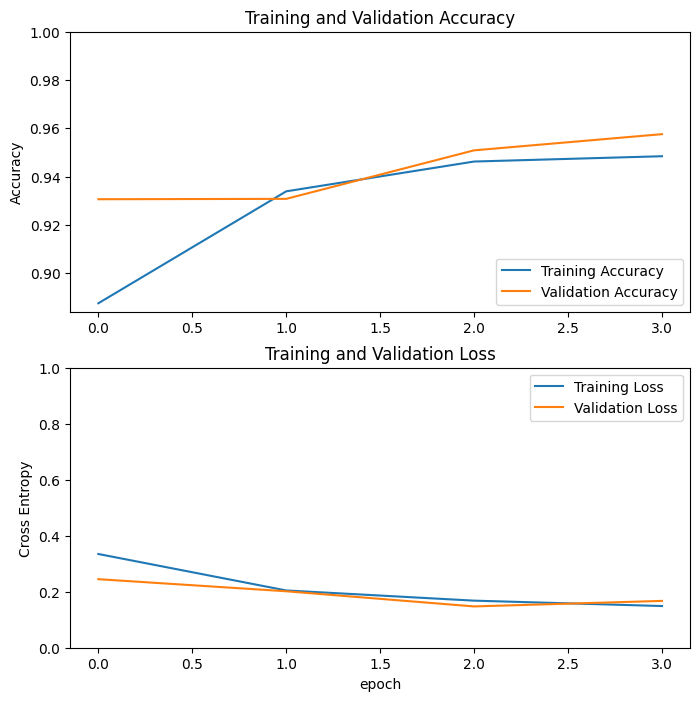

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

2023-02-04 17:28:27.381365: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 121 of 10000
2023-02-04 17:28:28.581387: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


Predictions:
 [2 2 0 0 0 0 2 0 2 0 0 1 1 1 2 1 1 0 0 2 0 2 0 0 0 1 2 2 1 1 2 1]
Labels:
 [2 2 0 0 0 0 2 0 2 0 0 1 2 2 2 1 2 0 0 2 0 2 0 0 0 1 2 2 1 1 2 1]


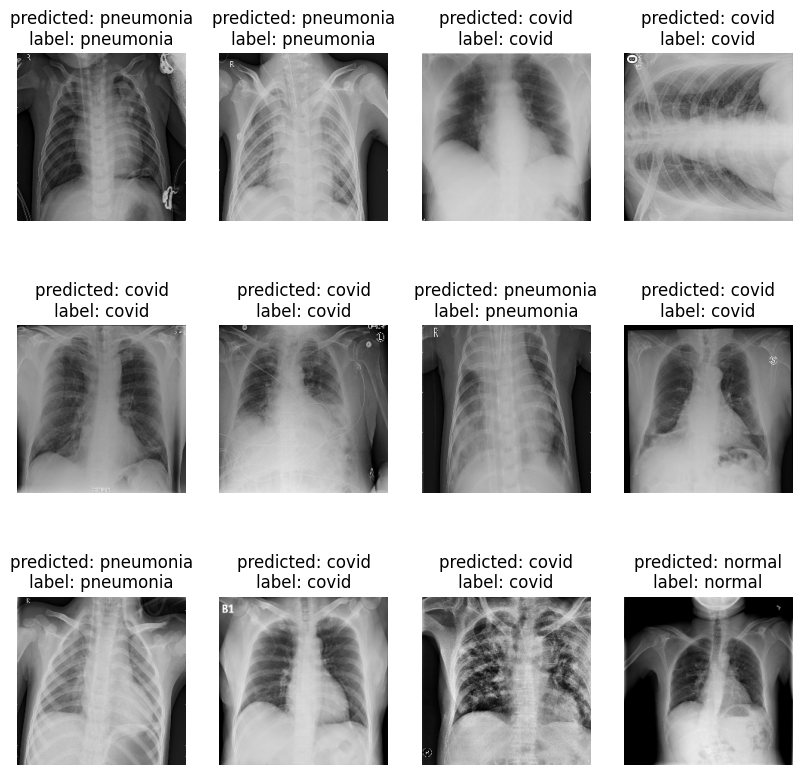

In [ ]:
#Retrieve a batch of images from the test set
class_names= dataset.class_names
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
y_true=label_batch
# Apply a sigmoid since our model returns logits
predictions = tf.nn.softmax(predictions)
y_pred_proba=np.amax(predictions,1)
predictions = np.argmax(predictions, 1)
y_pred=predictions
print('Predictions:\n', predictions)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(12):
  ax = plt.subplot(3, 4, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title('predicted: ' + class_names[predictions[i]]+'\n'+ 'label: ' +class_names[label_batch[i]])
  plt.axis("off")